In [1]:
import os

import numpy as np
from sklearn.decomposition import PCA

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt


from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0"
module = "encoder"
task = "wic"

In [3]:
# assertions
assert model == "bigscience-T0"
assert module == "encoder"
assert task == "wic"

## Prompts

In [4]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

name  \
0                  gpt_3_without_targets   
1              gpt_3_yes_no_with_targets   
2               affirmation_with_targets   
3          grammar_homework_with_targets   
4                polysemous_with_targets   
5       question_context_without_targets   
6       question_meaning_without_targets   
7   question_meaning_yes_no_with_targets   
8                same_sense_with_targets   
9          similar_sense_without_targets   
10     similar_sense_yes_no_with_targets   
11         gpt_3_true_false_with_targets   
12            gpt_3_cat_dog_with_targets   

                                             template     category  \
0   {sentence1} {sentence2} Question: Is the word ...  instructive   
1   {sentence1} {sentence2} Question: Is the word ...  instructive   
2   Sentence A: {sentence1} Sentence B: {sentence2...  instructive   
3   Decide whether the word "{word}" is used with ...  instructive   
4   The word "{word}" has multiple meanings. Does ...  instructive   
5   Determine if the word "{word}" is used in the ...  instructive   
6   Determine if the word "{word}" have the same m...  instructive   
7   Does the word "{word}" have the same meanining...  instructive   
8   Sentence 1: {sentence1} Sentence 2: {sentence2...  instructive   
9    {sentence1} {sentence2} Similar sense of {word}?  instructive   
10  {sentence1} {sentence2} Similar sense of {word...  instructive   
11  {sentence1} {sentence2} Question: Is the word ...  instructive   
12  {sentence1} {sentence2} Question: Is the word ...  instructive   

    includes_targets               targets  target_ids  shuffle  
0              False  ▁No, ▁no, ▁Yes, ▁yes  0, 0, 1, 1    False  
1               True             ▁No, ▁Yes        0, 1    False  
2               True           ▁Fal, ▁True        0, 1    False  
3               True             ▁No, ▁Yes        0, 1    False  
4               True             ▁No, ▁Yes        0, 1    False  
5              False  ▁No, ▁no, ▁Yes, ▁yes  0, 0, 1, 1    False  
6              False  ▁No, ▁no, ▁Yes, ▁yes  0, 0, 1, 1    False  
7               True             ▁No, ▁Yes        0, 1    False  
8               True             ▁No, ▁Yes        0, 1    False  
9              False  ▁No, ▁no, ▁Yes, ▁yes  0, 0, 1, 1    False  
10              True             ▁No, ▁Yes        0, 1    False  
11              True           ▁Fal, ▁True        0, 1    False  
12              True            ▁Cat, ▁Dog        0, 1    False

## PCA

In [5]:
def unison_shuffled_copies(a, b):
    # from: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [6]:
use_pattern = [
    "gpt_3_without_targets",
    "gpt_3_yes_no_with_targets",
    # "affirmation_with_targets",
    "grammar_homework_with_targets",
    # "polysemous_with_targets",
    # "question_context_without_targets",
    # "question_meaning_without_targets",
    # "question_meaning_yes_no_with_targets",
    # "same_sense_with_targets",
    # "similar_sense_without_targets",
    # "similar_sense_yes_no_with_targets",
    "gpt_3_true_false_with_targets",
    "gpt_3_cat_dog_with_targets",
]

In [7]:
# for layer in range(0, 10):
for layer in range(0, 25):
# for layer in range(24, 25):
    print('layer=', layer)
    file_names, prompt_names = [], []

    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5",)
            prompt_names.append(row['name'])


    # load hidden representations from hdf5 file
    representations = None
    classes = []
    n_sequences = 0

    for idx, file_name in enumerate(file_names):
        hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
        # print(hidden_representations.shape)
        n_sequences = hidden_representations.shape[0]

        if representations is None:
            representations = hidden_representations
        else:
            representations = np.concatenate((representations, hidden_representations), axis=0)

        classes += n_sequences * [idx] # assign representations to classes
    
    classes = np.asarray(classes)

    # shuffle representations and classes
    X, y = unison_shuffled_copies(representations, classes)
    print(X.shape, y.shape)

    # perform PCA on hidden representations
    print('PCA for prompts:', prompt_names)

    for n_components in range(1, 3):
        pca = PCA(n_components=n_components)
        pca.fit(X)

        # variance explained by each of the principal components
        print(f"model:{model}; module:{module}; layer:{layer}; n_components: {n_components}; variance explained: {pca.explained_variance_ratio_}")
        print(np.sum(pca.explained_variance_ratio_))
    print('\n')


layer= 0


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5692.49it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:0; n_components: 1; variance explained: [0.66382694]
0.66382694
model:bigscience-T0; module:encoder; layer:0; n_components: 2; variance explained: [0.6638271  0.03142041]
0.69524753


layer= 1


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5805.68it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:1; n_components: 1; variance explained: [0.08615143]
0.08615143
model:bigscience-T0; module:encoder; layer:1; n_components: 2; variance explained: [0.0861515  0.07688015]
0.16303165


layer= 2


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5725.22it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:2; n_components: 1; variance explained: [0.08259483]
0.08259483
model:bigscience-T0; module:encoder; layer:2; n_components: 2; variance explained: [0.0825948  0.06692356]
0.14951836


layer= 3


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5805.29it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:3; n_components: 1; variance explained: [0.0821888]
0.0821888
model:bigscience-T0; module:encoder; layer:3; n_components: 2; variance explained: [0.0821888  0.06437264]
0.14656144


layer= 4


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5831.94it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:4; n_components: 1; variance explained: [0.0851964]
0.0851964
model:bigscience-T0; module:encoder; layer:4; n_components: 2; variance explained: [0.08519636 0.06142875]
0.1466251


layer= 5


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5941.36it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:5; n_components: 1; variance explained: [0.08271497]
0.08271497
model:bigscience-T0; module:encoder; layer:5; n_components: 2; variance explained: [0.08271492 0.05891554]
0.14163046


layer= 6


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5670.96it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:6; n_components: 1; variance explained: [0.08254597]
0.082545966
model:bigscience-T0; module:encoder; layer:6; n_components: 2; variance explained: [0.08254591 0.06659196]
0.14913787


layer= 7


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5771.94it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:7; n_components: 1; variance explained: [0.08545443]
0.08545443
model:bigscience-T0; module:encoder; layer:7; n_components: 2; variance explained: [0.0854544  0.07585545]
0.16130984


layer= 8


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5924.43it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:8; n_components: 1; variance explained: [0.09959617]
0.09959617
model:bigscience-T0; module:encoder; layer:8; n_components: 2; variance explained: [0.09959619 0.07728627]
0.17688245


layer= 9


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5896.98it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:9; n_components: 1; variance explained: [0.10281668]
0.10281668
model:bigscience-T0; module:encoder; layer:9; n_components: 2; variance explained: [0.10281657 0.07365856]
0.17647512


layer= 10


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5759.45it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:10; n_components: 1; variance explained: [0.10502208]
0.10502208
model:bigscience-T0; module:encoder; layer:10; n_components: 2; variance explained: [0.10502224 0.07479159]
0.17981383


layer= 11


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 4616.27it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:11; n_components: 1; variance explained: [0.7761623]
0.7761623
model:bigscience-T0; module:encoder; layer:11; n_components: 2; variance explained: [0.7761623 0.0265942]
0.80275655


layer= 12


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5811.03it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:12; n_components: 1; variance explained: [0.7543571]
0.7543571
model:bigscience-T0; module:encoder; layer:12; n_components: 2; variance explained: [0.7543571  0.02960597]
0.7839631


layer= 13


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5169.84it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:13; n_components: 1; variance explained: [0.75571096]
0.75571096
model:bigscience-T0; module:encoder; layer:13; n_components: 2; variance explained: [0.75571096 0.0289213 ]
0.78463227


layer= 14


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5914.38it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:14; n_components: 1; variance explained: [0.7401271]
0.7401271
model:bigscience-T0; module:encoder; layer:14; n_components: 2; variance explained: [0.7401271  0.02990199]
0.77002907


layer= 15


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5961.93it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:15; n_components: 1; variance explained: [0.7263391]
0.7263391
model:bigscience-T0; module:encoder; layer:15; n_components: 2; variance explained: [0.72633904 0.03057488]
0.7569139


layer= 16


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5852.25it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:16; n_components: 1; variance explained: [0.71671546]
0.71671546
model:bigscience-T0; module:encoder; layer:16; n_components: 2; variance explained: [0.71671546 0.03160863]
0.7483241


layer= 17


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5657.92it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:17; n_components: 1; variance explained: [0.70652765]
0.70652765
model:bigscience-T0; module:encoder; layer:17; n_components: 2; variance explained: [0.70652765 0.03268723]
0.7392149


layer= 18


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5694.96it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:18; n_components: 1; variance explained: [0.6735813]
0.6735813
model:bigscience-T0; module:encoder; layer:18; n_components: 2; variance explained: [0.6735813  0.04294632]
0.71652764


layer= 19


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5730.72it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:19; n_components: 1; variance explained: [0.64360183]
0.64360183
model:bigscience-T0; module:encoder; layer:19; n_components: 2; variance explained: [0.64360183 0.05621747]
0.6998193


layer= 20


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5940.08it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:20; n_components: 1; variance explained: [0.48387572]
0.48387572
model:bigscience-T0; module:encoder; layer:20; n_components: 2; variance explained: [0.48387596 0.15774454]
0.6416205


layer= 21


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5821.94it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:21; n_components: 1; variance explained: [0.39458004]
0.39458004
model:bigscience-T0; module:encoder; layer:21; n_components: 2; variance explained: [0.3945802  0.24801797]
0.64259815


layer= 22


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5859.43it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:22; n_components: 1; variance explained: [0.5090262]
0.5090262
model:bigscience-T0; module:encoder; layer:22; n_components: 2; variance explained: [0.50902635 0.1793759 ]
0.68840224


layer= 23


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5937.07it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:23; n_components: 1; variance explained: [0.58037066]
0.58037066
model:bigscience-T0; module:encoder; layer:23; n_components: 2; variance explained: [0.58037066 0.12118097]
0.7015516


layer= 24


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5913.33it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
model:bigscience-T0; module:encoder; layer:24; n_components: 1; variance explained: [0.20342351]
0.20342351
model:bigscience-T0; module:encoder; layer:24; n_components: 2; variance explained: [0.20342365 0.09754939]
0.30097306




## Visualize PCA

layer= 0


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 6014.60it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:0; n_components: 2; variance explained: [0.66382736 0.03142041]
0.69524777


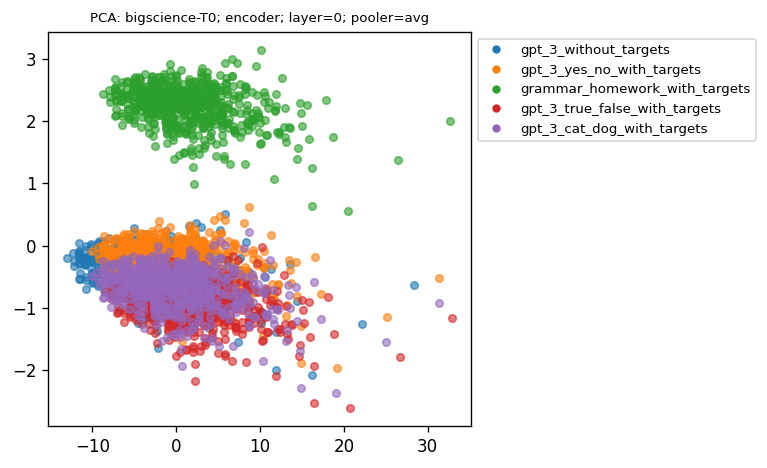



layer= 1


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5875.57it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:1; n_components: 2; variance explained: [0.08615153 0.07688018]
0.1630317


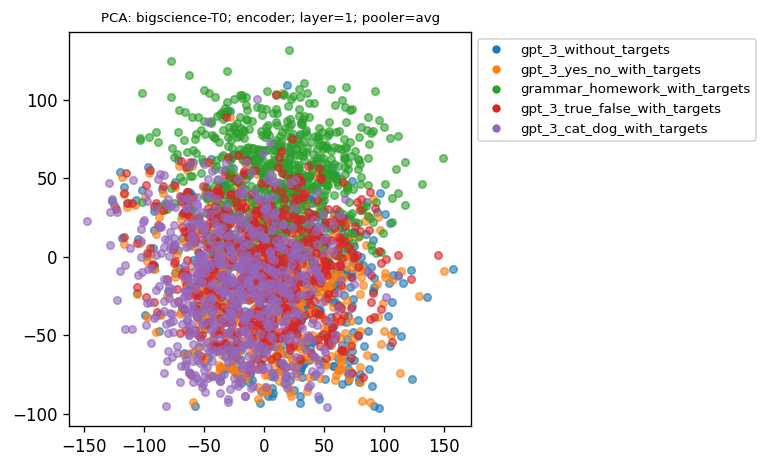



layer= 2


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5633.91it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:2; n_components: 2; variance explained: [0.08259474 0.06692357]
0.14951831


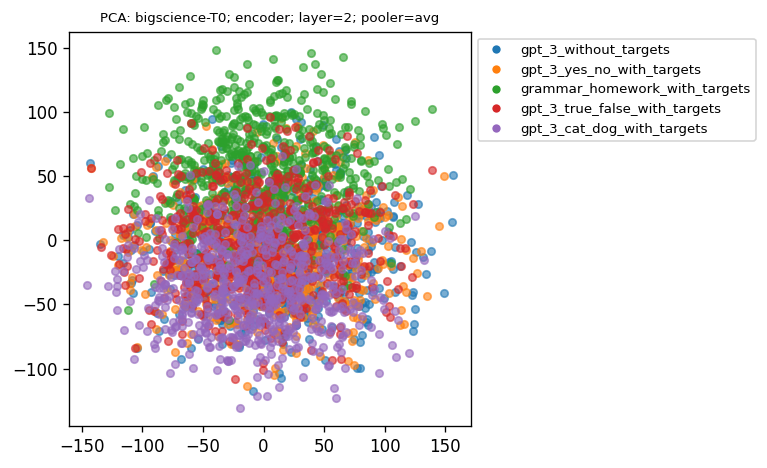



layer= 3


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5739.58it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:3; n_components: 2; variance explained: [0.08218886 0.06437263]
0.14656149


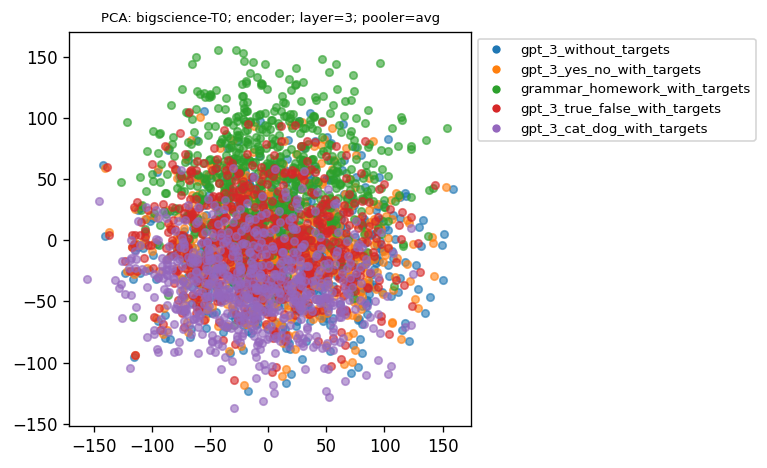



layer= 4


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5686.43it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:4; n_components: 2; variance explained: [0.08519643 0.06142873]
0.14662516


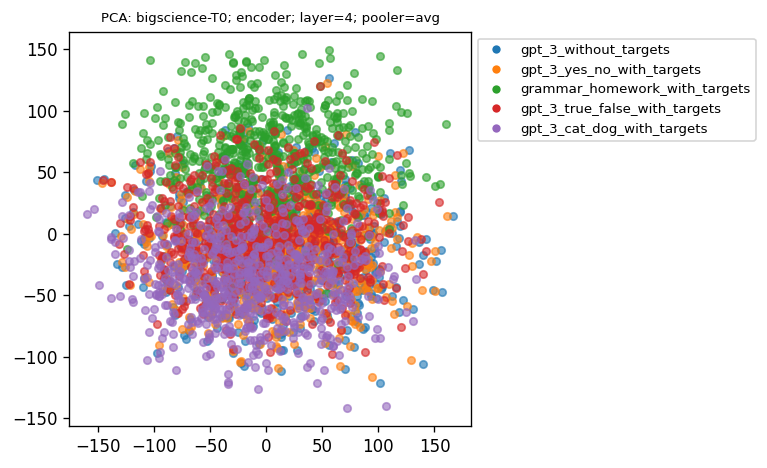



layer= 5


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5574.82it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:5; n_components: 2; variance explained: [0.08271502 0.05891547]
0.14163049


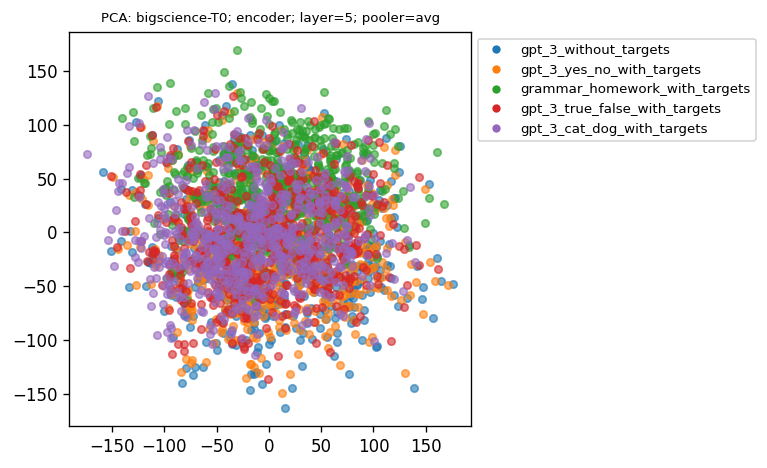



layer= 6


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5515.67it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:6; n_components: 2; variance explained: [0.08254592 0.06659188]
0.1491378


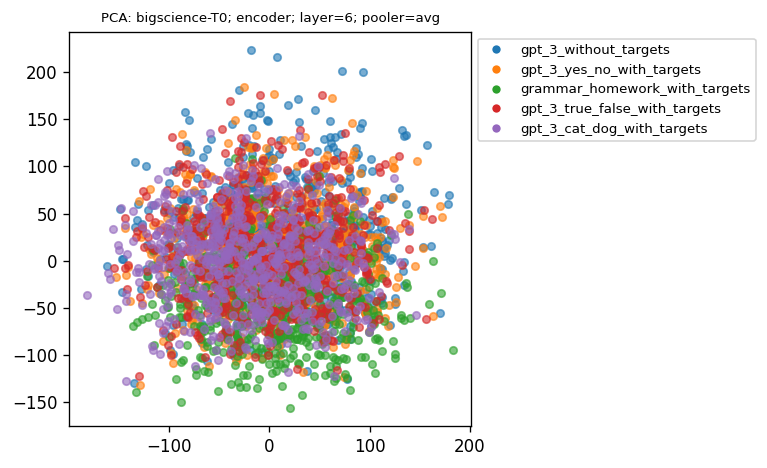



layer= 7


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5576.56it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:7; n_components: 2; variance explained: [0.08545435 0.07585535]
0.1613097


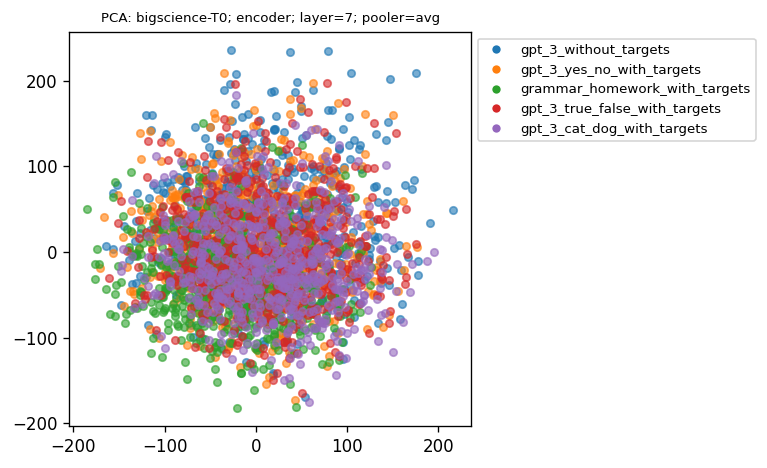



layer= 8


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5620.08it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:8; n_components: 2; variance explained: [0.09959623 0.07728621]
0.17688245


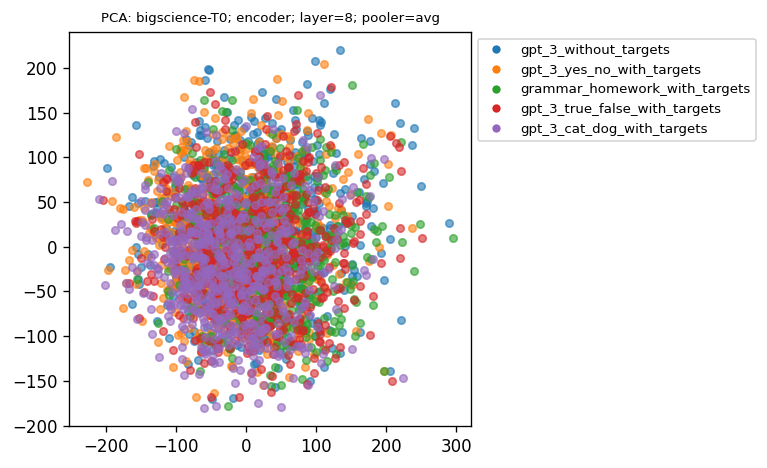



layer= 9


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5857.02it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:9; n_components: 2; variance explained: [0.10281659 0.07365863]
0.17647523


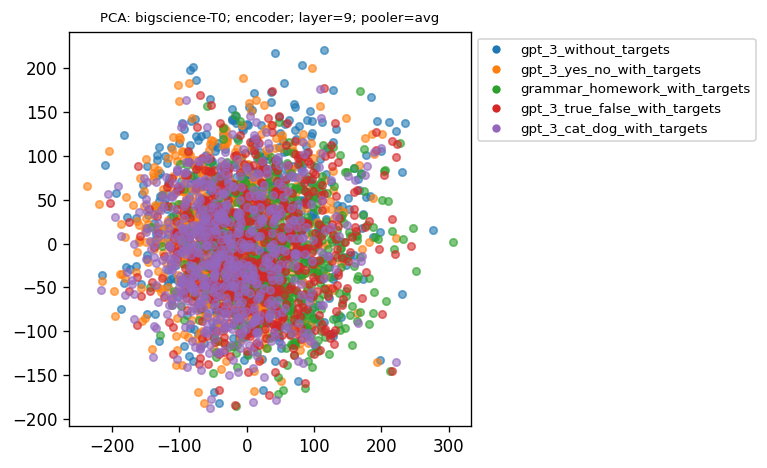



layer= 10


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5687.66it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:10; n_components: 2; variance explained: [0.10502207 0.07479156]
0.17981362


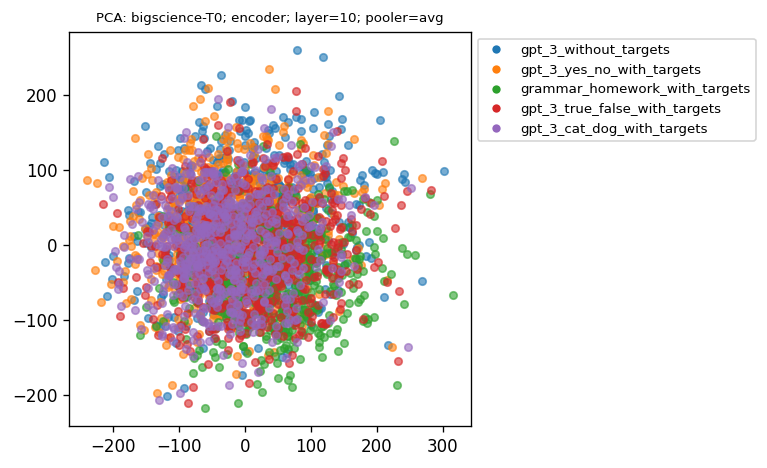



layer= 11


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5593.40it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:11; n_components: 2; variance explained: [0.7761623  0.02659419]
0.8027565


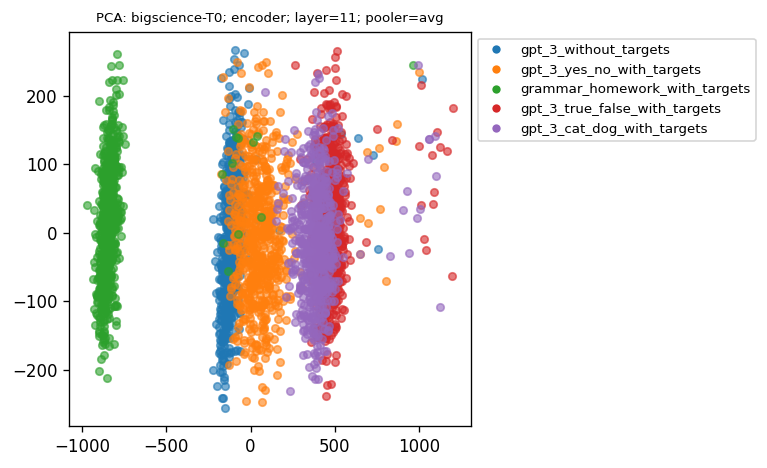



layer= 12


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5704.27it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:12; n_components: 2; variance explained: [0.7543571  0.02960594]
0.783963


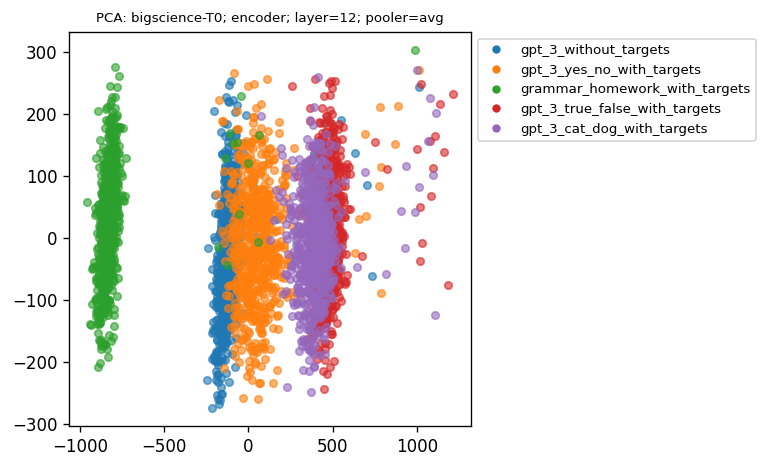



layer= 13


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5698.27it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:13; n_components: 2; variance explained: [0.75571096 0.02892131]
0.78463227


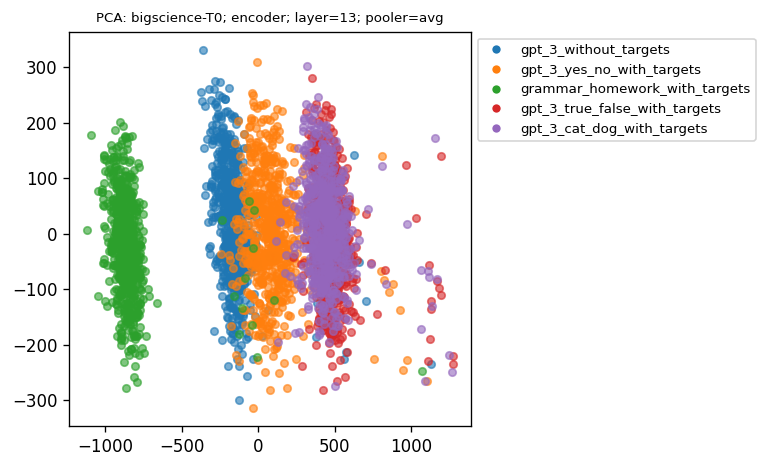



layer= 14


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 4764.57it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:14; n_components: 2; variance explained: [0.74012697 0.02990201]
0.77002895


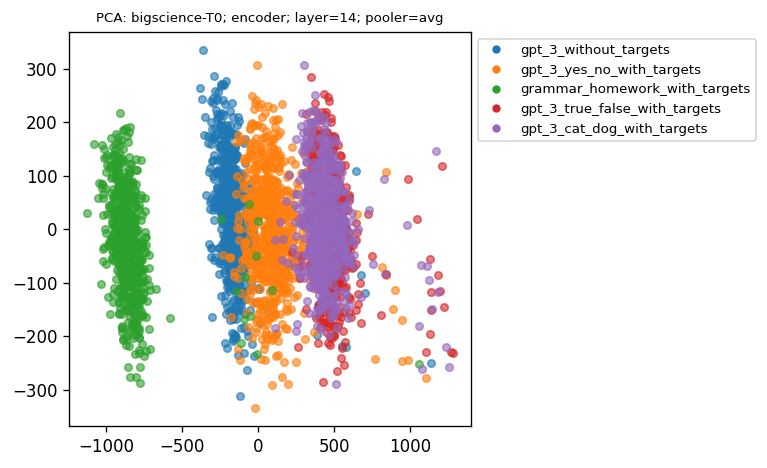



layer= 15


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5247.96it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:15; n_components: 2; variance explained: [0.72633916 0.03057488]
0.756914


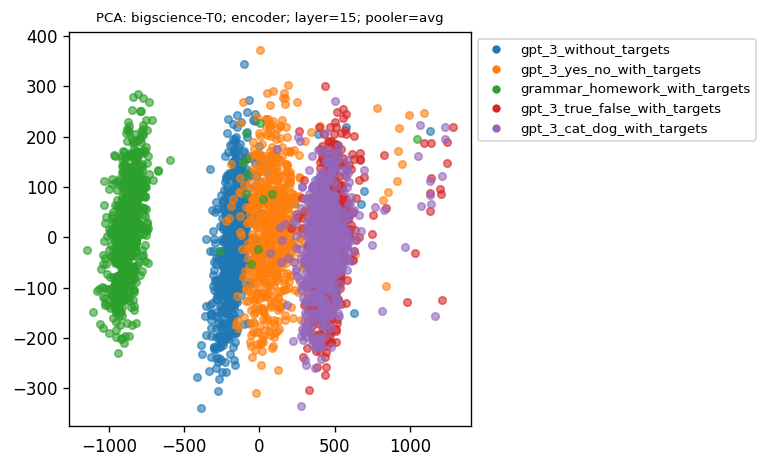



layer= 16


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5168.20it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:16; n_components: 2; variance explained: [0.71671563 0.03160863]
0.7483243


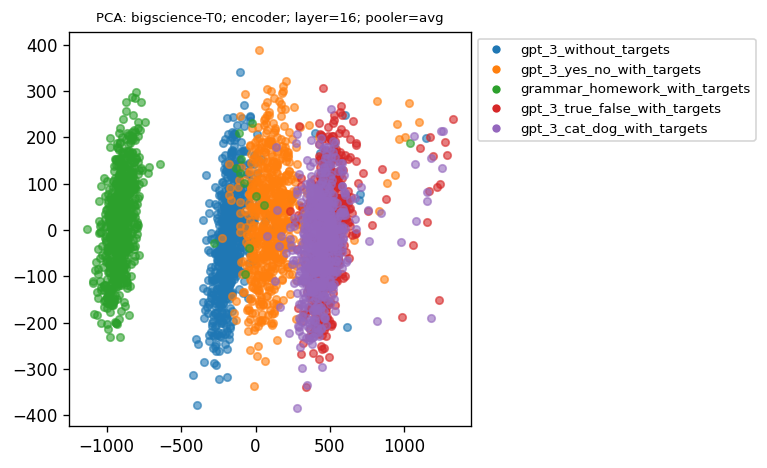



layer= 17


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5681.58it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:17; n_components: 2; variance explained: [0.70652765 0.03268724]
0.7392149


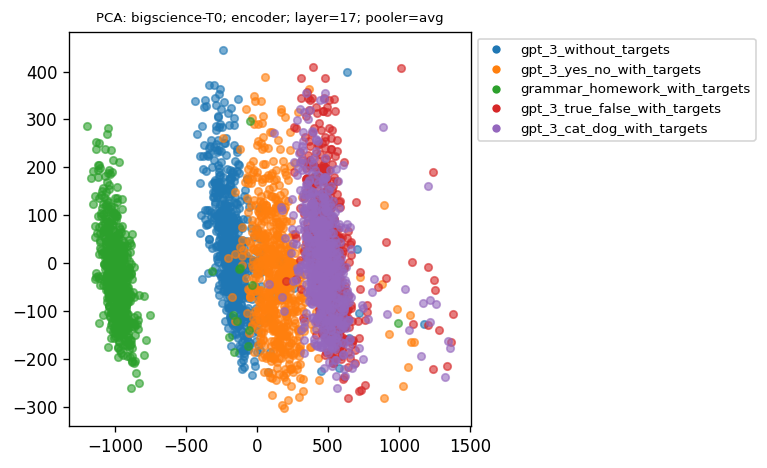



layer= 18


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5738.02it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:18; n_components: 2; variance explained: [0.67358124 0.04294632]
0.7165276


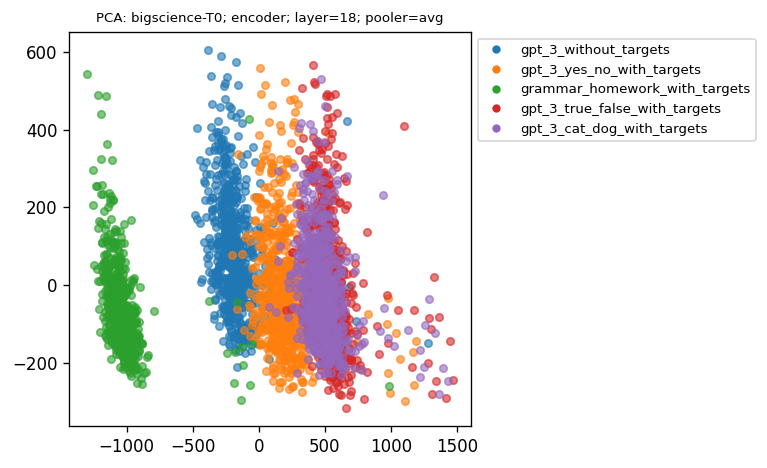



layer= 19


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5654.86it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:19; n_components: 2; variance explained: [0.64360166 0.05621746]
0.6998191


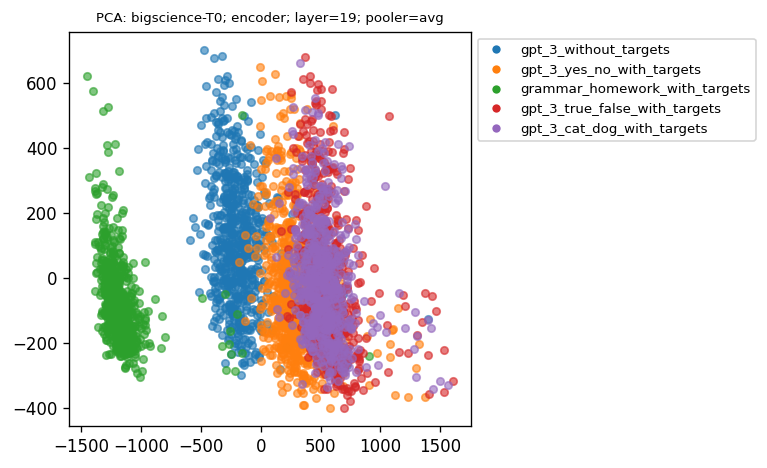



layer= 20


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5814.12it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:20; n_components: 2; variance explained: [0.4838758  0.15774441]
0.6416202


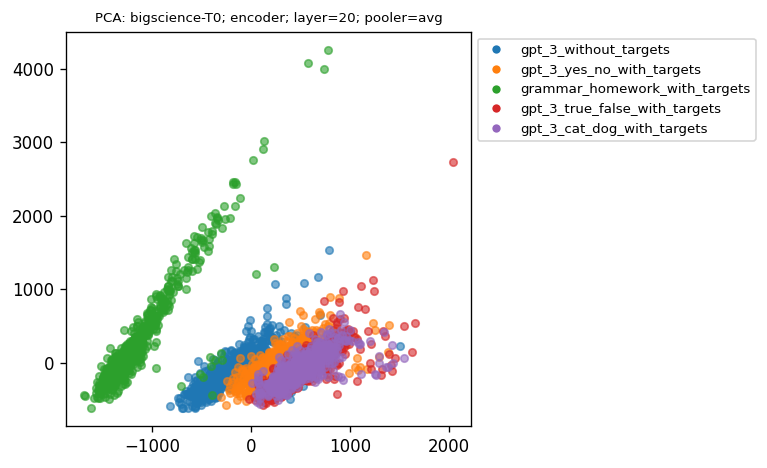



layer= 21


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5033.94it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:21; n_components: 2; variance explained: [0.39458013 0.24801792]
0.64259803


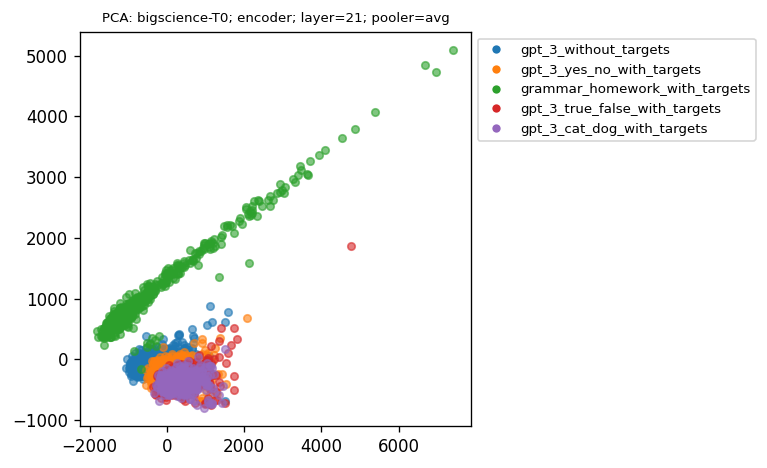



layer= 22


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5765.71it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:22; n_components: 2; variance explained: [0.5090261 0.1793759]
0.688402


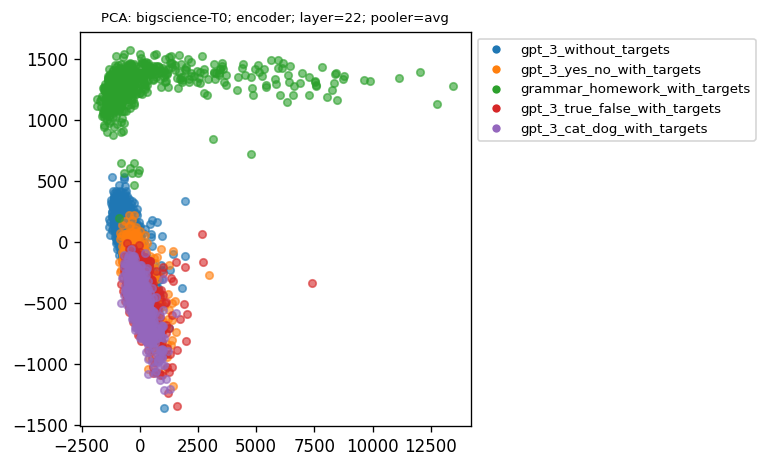



layer= 23


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5689.14it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:23; n_components: 2; variance explained: [0.5803707  0.12118097]
0.7015517


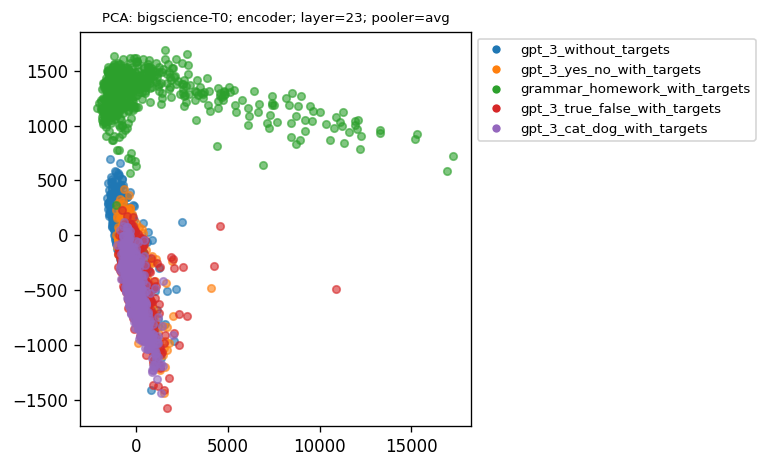



layer= 24


Reading embeddings: 100%|██████████| 638/638 [00:00<00:00, 5482.50it/s]


(3190, 4096) (3190,)
PCA for prompts: ['gpt_3_without_targets', 'gpt_3_yes_no_with_targets', 'grammar_homework_with_targets', 'gpt_3_true_false_with_targets', 'gpt_3_cat_dog_with_targets']
(3190, 2)
model:bigscience-T0; module:encoder; layer:24; n_components: 2; variance explained: [0.2034236  0.09754939]
0.300973


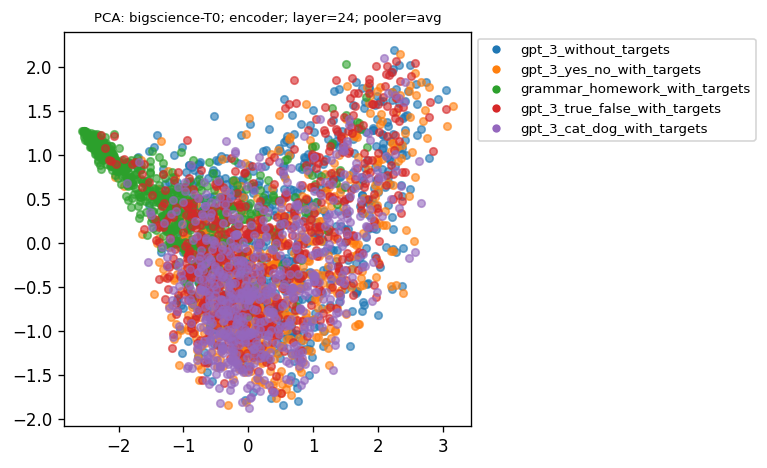

In [8]:
cmap = matplotlib.cm.get_cmap('tab10')
# cmap = matplotlib.cm.get_cmap('tab20')
colors = cmap.colors

# for layer in range(0, 1):
for layer in range(0, 25):
# for layer in range(24, 25):
    print('layer=', layer)
    file_names, prompt_names = [], []

    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5",)
            prompt_names.append(row['name'])


    # load hidden representations from hdf5 file
    representations = None
    classes = []
    n_sequences = 0

    for idx, file_name in enumerate(file_names):
        hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
        # print(hidden_representations.shape)
        n_sequences = hidden_representations.shape[0]

        if representations is None:
            representations = hidden_representations
        else:
            representations = np.concatenate((representations, hidden_representations), axis=0)

        classes += n_sequences * [idx] # assign representations to classes
    
    classes = np.asarray(classes)

    X, y = representations, classes
    # shuffle representations and classes
    # X, y = unison_shuffled_copies(representations, classes)
    print(X.shape, y.shape)

    # perform PCA on hidden representations
    print('PCA for prompts:', prompt_names)

    for n_components in range(2, 3):
        pca = PCA(n_components=n_components)
        X_pca = pca.fit(X).transform(X)
        print(X_pca.shape)

        # variance explained by each of the principal components
        print(f"model:{model}; module:{module}; layer:{layer}; n_components: {n_components}; variance explained: {pca.explained_variance_ratio_}")
        print(np.sum(pca.explained_variance_ratio_))

        # plot PCA embeddings
        fig, axes = plt.subplots(1, 1, figsize=(6.5,4), dpi=120)
        legend_elements= []

        for idx, file_name in enumerate(file_names):
            x, y = X_pca[n_sequences*idx:n_sequences*(idx + 1), 0], X_pca[n_sequences*idx:n_sequences*(idx + 1), 1]
            axes.scatter(x, y, alpha=0.6, s=[20.0], color=colors[idx])

            # create legend element manually
            legend_elements.append(Line2D([0], [0], marker='o', color='w', label=prompt_names[idx], markerfacecolor=colors[idx], markersize=6))
        
        axes.set_title(f"PCA: {model}; {module}; layer={layer}; pooler=avg", fontsize=8)
        axes.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

        plt.tight_layout()

        plt.show()
        plt.close();
        
    print('\n')
